<a href="https://colab.research.google.com/github/ethantlogan/FWE_458/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 42.9 MB/s eta 0:00:00


In [ ]:
!pip install cartopy openpyxl


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/FWE458/gfw_2023_statistics_summary_v30102024 (1).xlsx'


Mounted at /content/drive


In [ ]:
import pandas as pd

# Load the spreadsheet
excel_file = pd.ExcelFile(file_path)
df = excel_file.parse('Country tree cover loss')

# Filter for threshold == 50
df_50 = df[df['threshold'] == 50].copy()

# Sum tree cover loss from 2001–2021
loss_cols = [col for col in df_50.columns if col.startswith("tc_loss_ha_20") and '2022' not in col and '2023' not in col]
df_50['total_tc_loss_2001_2021'] = df_50[loss_cols].sum(axis=1)

# Compute net tree cover change
df_50['net_tc_change_2001_2021'] = df_50['gain_2000-2020_ha'] - df_50['total_tc_loss_2001_2021']


df_50


,country,threshold,area_ha,extent_2000_ha,extent_2010_ha,gain_2000-2020_ha,tc_loss_ha_2001,tc_loss_ha_2002,tc_loss_ha_2003,tc_loss_ha_2004,...,tc_loss_ha_2016,tc_loss_ha_2017,tc_loss_ha_2018,tc_loss_ha_2019,tc_loss_ha_2020,tc_loss_ha_2021,tc_loss_ha_2022,tc_loss_ha_2023,total_tc_loss_2001_2021,net_tc_change_2001_2021
6,Afghanistan,50,64385715,148430,46242,10741,78,135,200,159,...,0,0,19,15,33,23,5,8,1465,9276
14,Akrotiri and Dhekelia,50,23448,336,238,42,1,1,0,2,...,9,1,1,1,0,1,0,0,36,6
22,Albania,50,2873537,534848,428833,16472,3402,837,533,2994,...,758,1372,1798,947,940,1371,1778,2258,37544,-21072
30,Algeria,50,230804377,895576,472785,89152,2427,2305,3019,3311,...,6004,37696,4295,4620,9831,15636,10492,17429,150396,-61244
38,Andorra,50,45196,16889,16179,120,2,1,0,20,...,0,3,14,7,26,2,14,6,110,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1854,Western Sahara,50,26732060,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1862,Yemen,50,45220898,10,22,7047,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7047
1870,Zambia,50,75049202,9185040,7213700,768157,19807,22499,21796,14157,...,55185,56191,50625,45404,56757,70026,61795,66264,859271,-91114
1878,Zimbabwe,50,39068111,293242,270037,151989,4221,3638,4204,4390,...,6099,15848,3157,6765,3314,3364,4237,2488,118682,33307


In [ ]:
# Install fuzzywuzzy for fuzzy string matching
!pip install fuzzywuzzy[speedup]

from fuzzywuzzy import process

# Get Cartopy country names from the Natural Earth shapefile
from cartopy.io.shapereader import natural_earth, Reader

shapename = 'admin_0_countries'
countries_shp = natural_earth(resolution='110m', category='cultural', name=shapename)
reader = Reader(countries_shp)
records = list(reader.records())
cartopy_names = [rec.attributes['NAME'] for rec in records]

# Fuzzy match your dataset's country names to Cartopy's country names
your_names = df_50['country'].unique()
name_match_dict = {}

for name in your_names:
    match, score = process.extractOne(name, cartopy_names)
    if score > 80:
        name_match_dict[name] = match

# Rename the index using the matched names
values = df_50.set_index('country')['net_tc_change_2001_2021']
mapped_values = values.rename(index=name_match_dict)


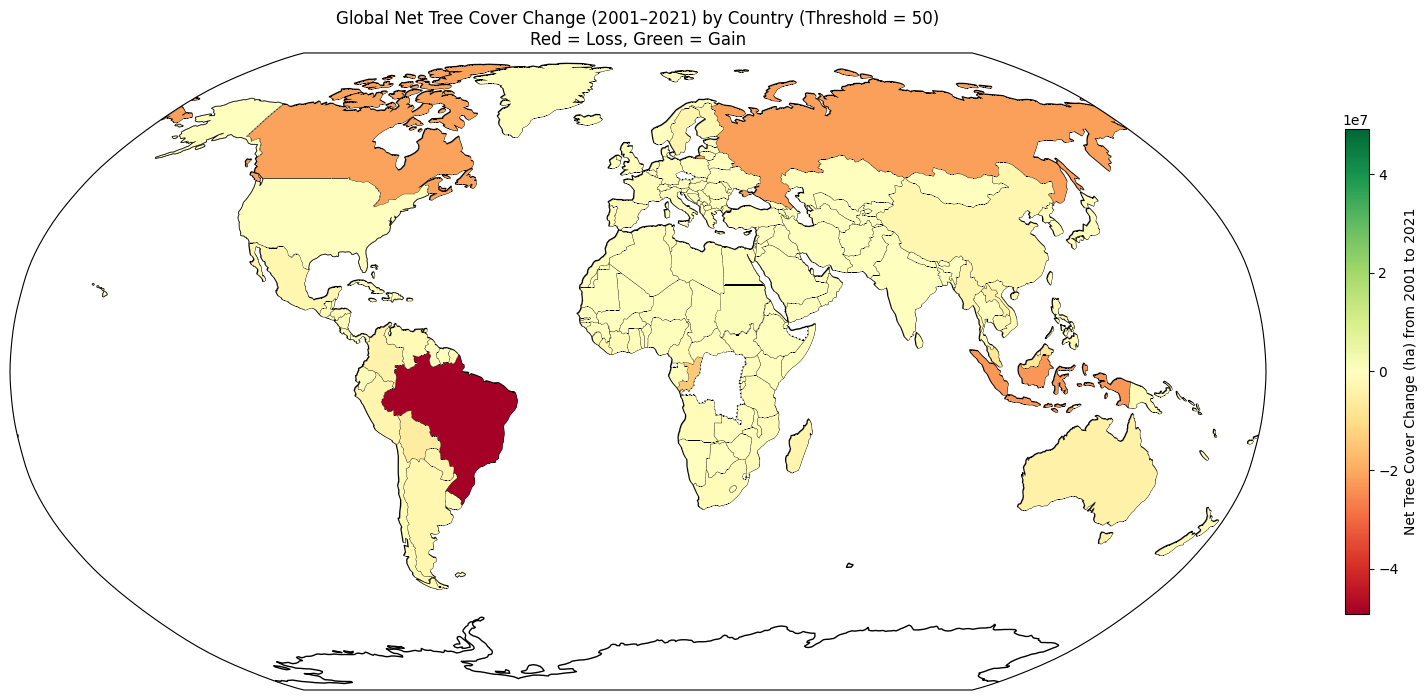

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Set up the map
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Use diverging colormap centered at 0
vmax = np.max(np.abs(mapped_values))
vmin = -vmax
cmap = plt.cm.RdYlGn  # Red = loss, Green = gain
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# Draw countries
for country in records:
    name = country.attributes['NAME']
    if name in mapped_values.index:
        val = mapped_values[name]
        color = cmap(norm(val))
        ax.add_geometries([country.geometry], ccrs.PlateCarree(),
                          facecolor=color, edgecolor='black', linewidth=0.2)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cbar.set_label('Net Tree Cover Change (ha) from 2001 to 2021')

plt.title('Global Net Tree Cover Change (2001–2021) by Country (Threshold = 50)\nRed = Loss, Green = Gain')
plt.tight_layout()
plt.show()


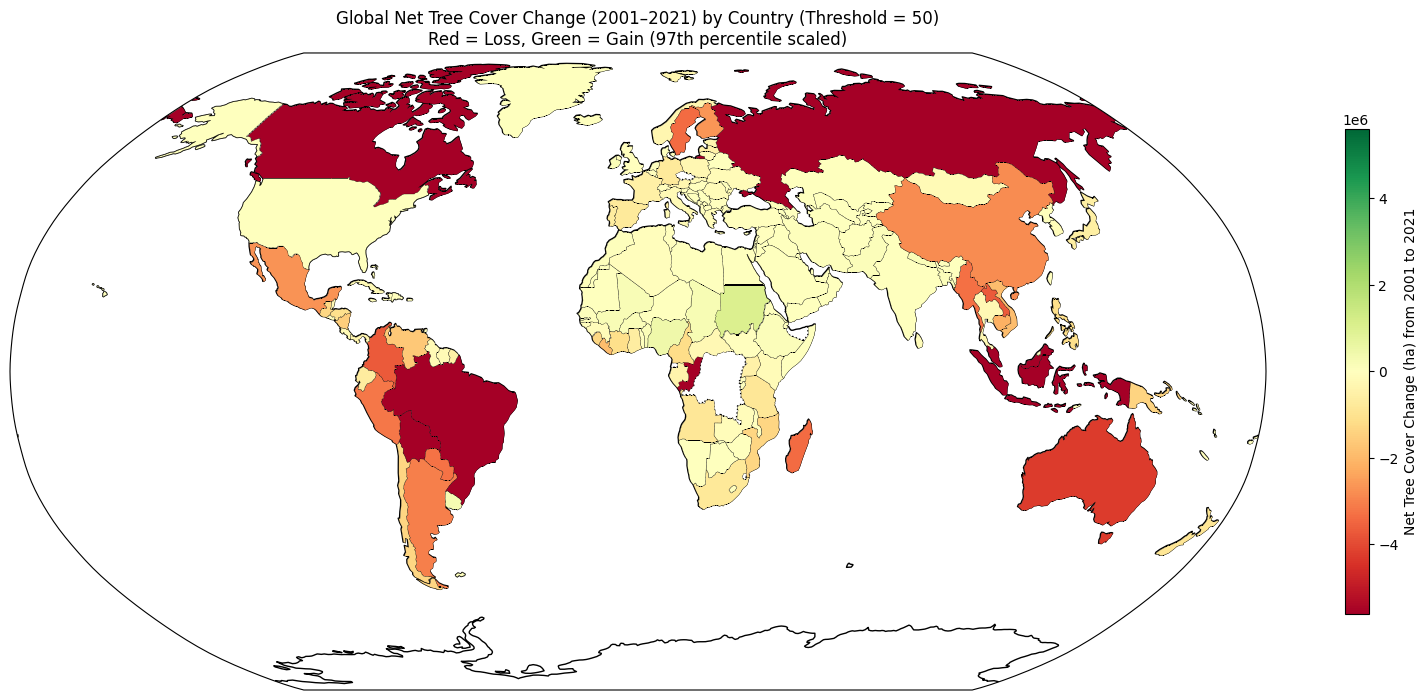

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from cartopy.io.shapereader import natural_earth, Reader

# Load Cartopy country shapes
shapename = 'admin_0_countries'
countries_shp = natural_earth(resolution='110m', category='cultural', name=shapename)
reader = Reader(countries_shp)
records = list(reader.records())

# Set up the map
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Use 97th percentile-based color scaling to reduce effect of outliers
percentile = 97
vmax = np.percentile(np.abs(mapped_values), percentile)
vmin = -vmax
cmap = plt.cm.RdYlGn  # Red = loss, Green = gain
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# Draw each country with color based on matched net tree cover change
for country in records:
    name = country.attributes['NAME']
    if name in mapped_values.index:
        val = mapped_values[name]
        color = cmap(norm(val))
        ax.add_geometries([country.geometry], ccrs.PlateCarree(),
                          facecolor=color, edgecolor='black', linewidth=0.2)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cbar.set_label('Net Tree Cover Change (ha) from 2001 to 2021')

plt.title('Global Net Tree Cover Change (2001–2021) by Country (Threshold = 50)\nRed = Loss, Green = Gain (97th percentile scaled)')
plt.tight_layout()
plt.show()


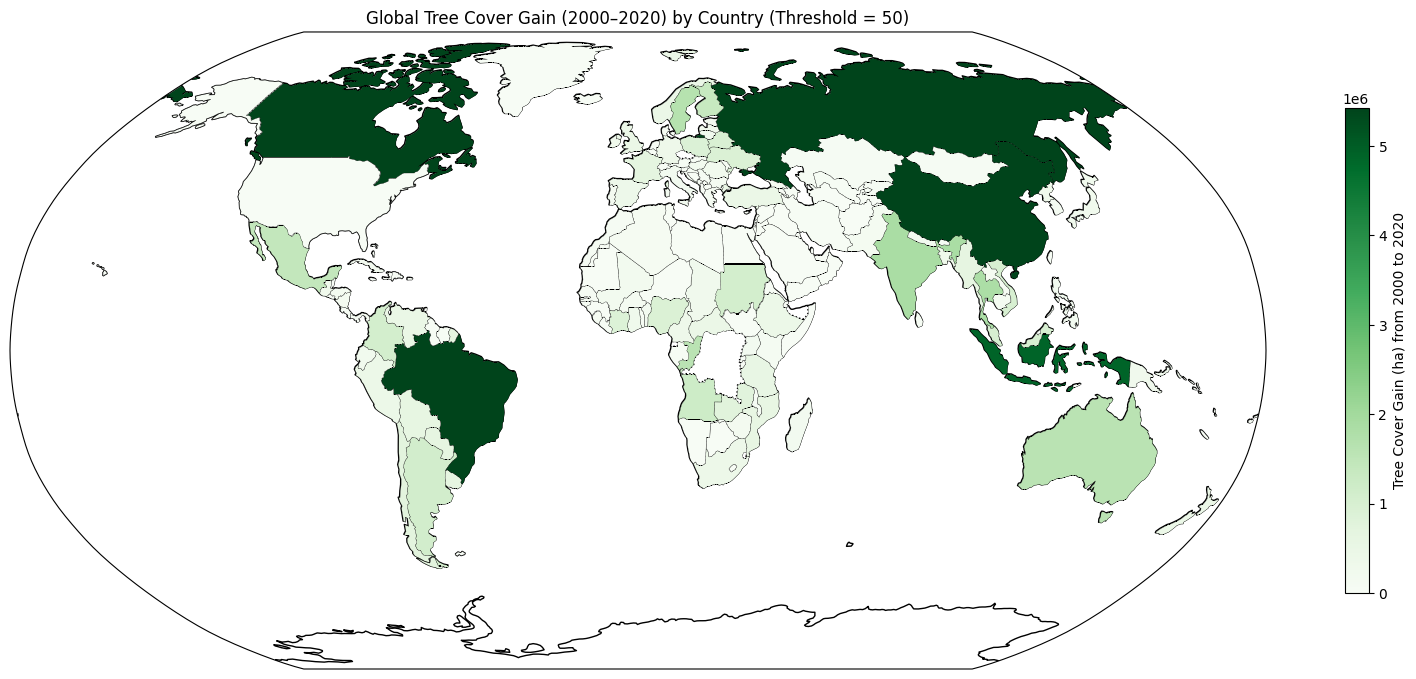

In [ ]:
# Get gain column
gain_values = df_50.set_index('country')['gain_2000-2020_ha']
gain_values = gain_values.rename(index=name_match_dict)

# 98th percentile color scaling
gain_vmax = np.percentile(gain_values, 98)
gain_norm = plt.Normalize(vmin=0, vmax=gain_vmax)

# Plot map
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

for country in records:
    name = country.attributes['NAME']
    if name in gain_values.index:
        val = gain_values[name]
        color = plt.cm.Greens(gain_norm(val))
        ax.add_geometries([country.geometry], ccrs.PlateCarree(),
                          facecolor=color, edgecolor='black', linewidth=0.2)

sm = plt.cm.ScalarMappable(cmap=plt.cm.Greens, norm=gain_norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cbar.set_label('Tree Cover Gain (ha) from 2000 to 2020')

plt.title('Global Tree Cover Gain (2000–2020) by Country (Threshold = 50)')
plt.tight_layout()
plt.show()


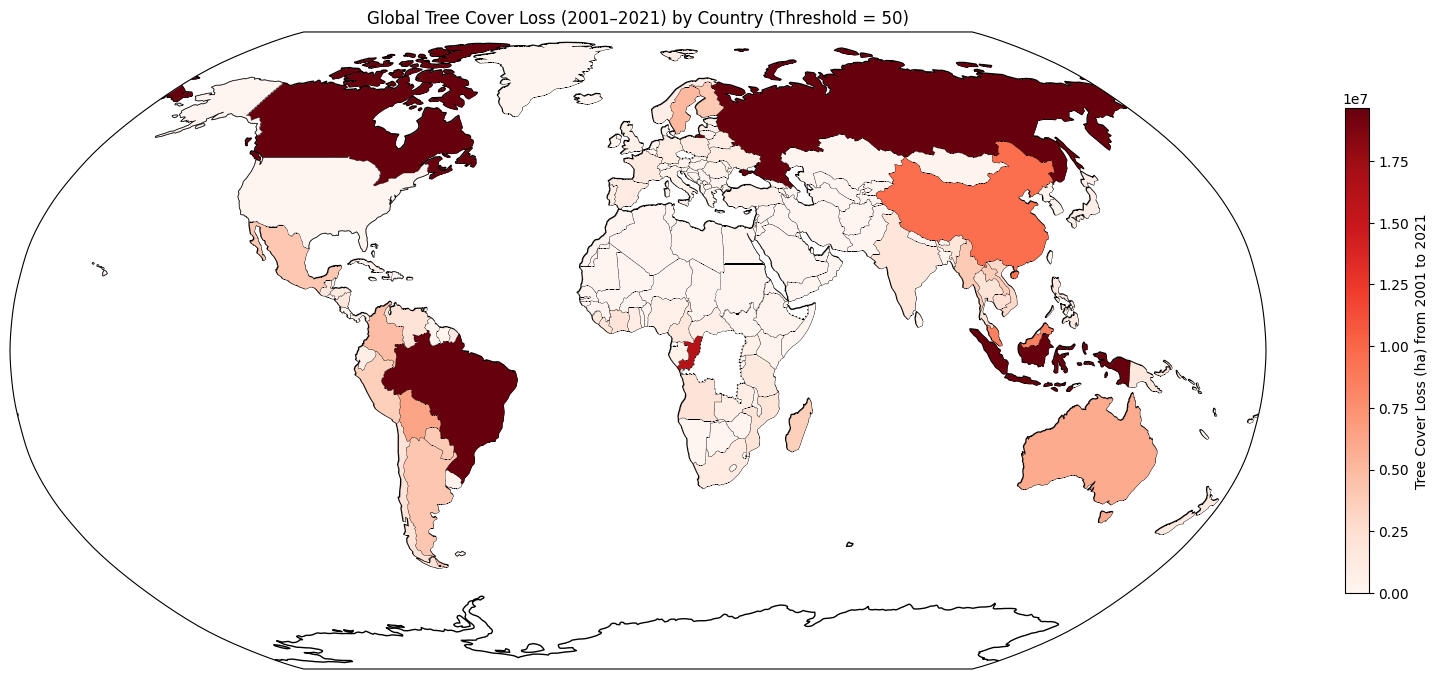

In [ ]:
# Get total loss from your existing df
loss_values = df_50.set_index('country')['total_tc_loss_2001_2021']
loss_values = loss_values.rename(index=name_match_dict)

# 98th percentile color scaling
loss_vmax = np.percentile(loss_values, 98)
loss_norm = plt.Normalize(vmin=0, vmax=loss_vmax)

# Plot map
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

for country in records:
    name = country.attributes['NAME']
    if name in loss_values.index:
        val = loss_values[name]
        color = plt.cm.Reds(loss_norm(val))
        ax.add_geometries([country.geometry], ccrs.PlateCarree(),
                          facecolor=color, edgecolor='black', linewidth=0.2)

sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=loss_norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cbar.set_label('Tree Cover Loss (ha) from 2001 to 2021')

plt.title('Global Tree Cover Loss (2001–2021) by Country (Threshold = 50)')
plt.tight_layout()
plt.show()


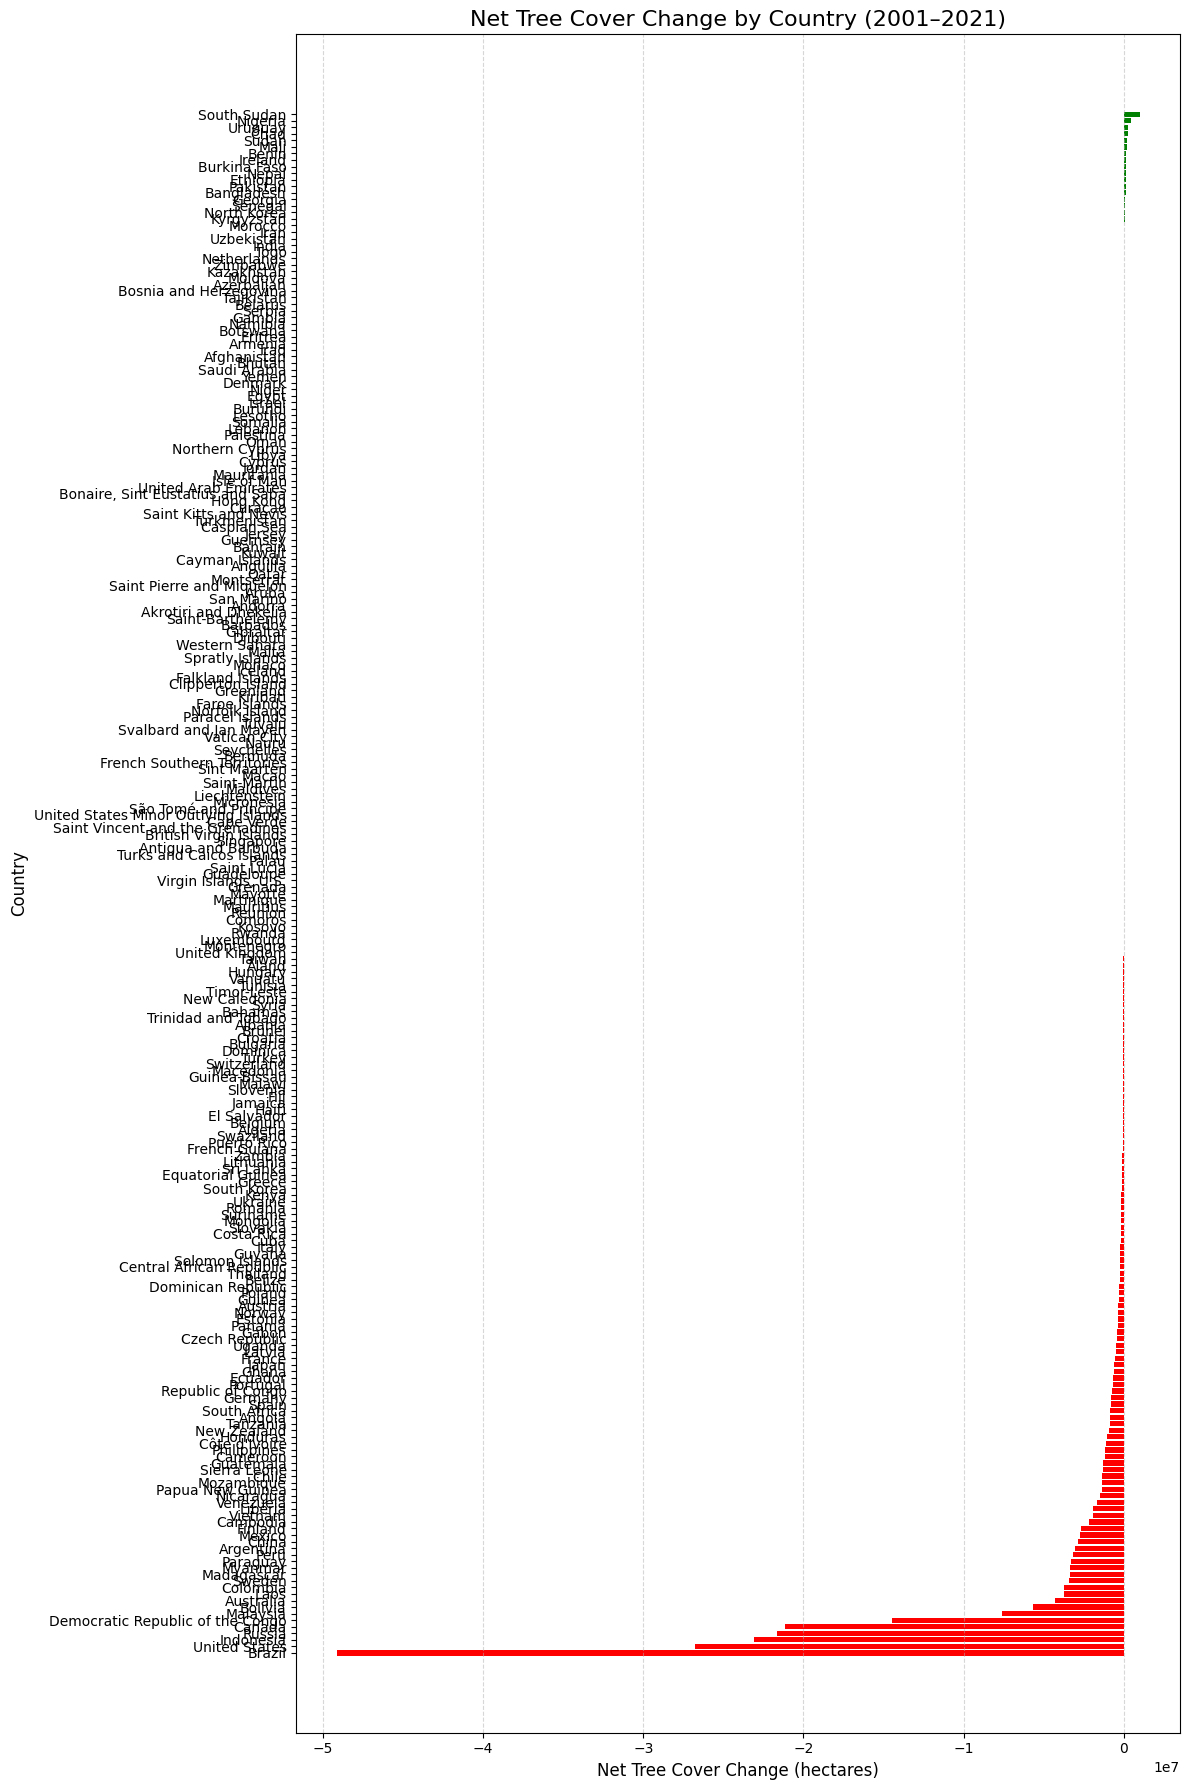

In [ ]:
import matplotlib.pyplot as plt

# Sort countries by net tree cover change
df_sorted = df_50.sort_values(by="net_tc_change_2001_2021", ascending=True)

plt.figure(figsize=(12, 18))  # Tall figure to fit all countries
bars = plt.barh(df_sorted['country'], df_sorted['net_tc_change_2001_2021'],
                color=df_sorted['net_tc_change_2001_2021'].apply(lambda x: 'red' if x < 0 else 'green'))

plt.title("Net Tree Cover Change by Country (2001–2021)", fontsize=16)
plt.xlabel("Net Tree Cover Change (hectares)", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


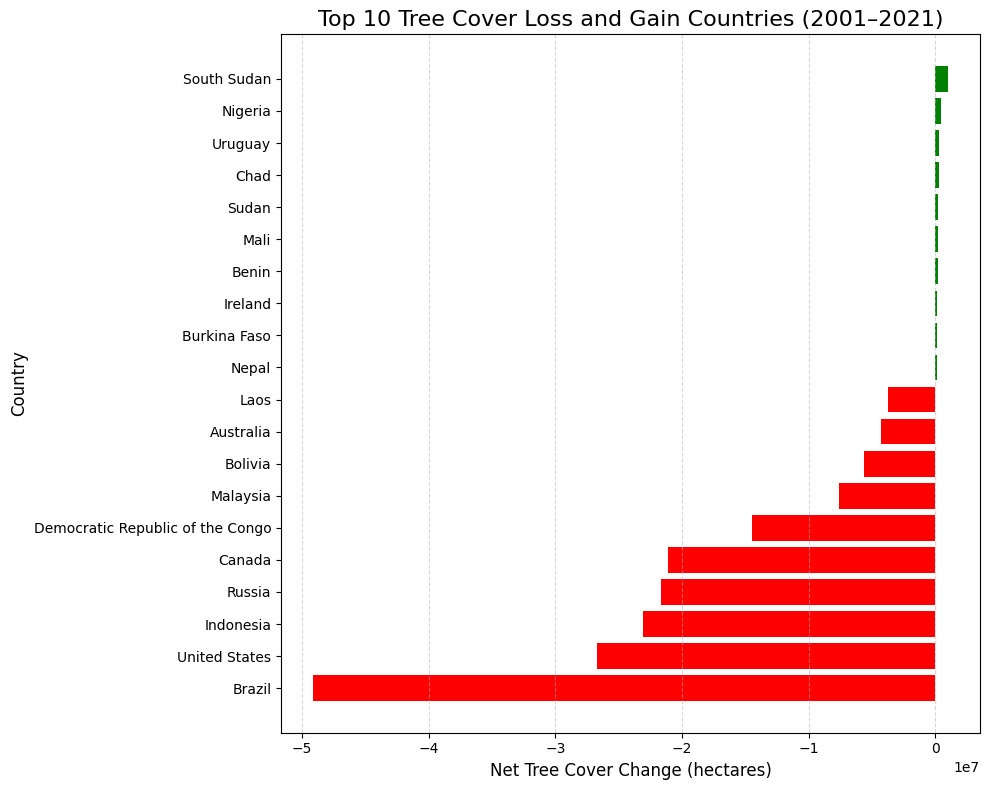

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Get top 10 loss and top 10 gain
top_loss = df_50.nsmallest(10, 'net_tc_change_2001_2021')
top_gain = df_50.nlargest(10, 'net_tc_change_2001_2021')

# Combine and sort for clean plot
top_combined = pd.concat([top_loss, top_gain]).sort_values(by='net_tc_change_2001_2021')

# Plot
plt.figure(figsize=(10, 8))
bars = plt.barh(top_combined['country'], top_combined['net_tc_change_2001_2021'],
                color=top_combined['net_tc_change_2001_2021'].apply(lambda x: 'red' if x < 0 else 'green'))

plt.title("Top 10 Tree Cover Loss and Gain Countries (2001–2021)", fontsize=16)
plt.xlabel("Net Tree Cover Change (hectares)", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:

!pip install xgboost --quiet

# Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import (
    r2_score, mean_squared_error,
    accuracy_score, precision_score, recall_score, f1_score
)
import warnings
warnings.filterwarnings("ignore")


# Input years and reshape
# Align years with the available data in total_tc_loss_2001_2021
years = np.arange(2001, 2022)  # Changed to 2022 to match the data
X = years.reshape(-1, 1)

# Classification metric helper
def get_classification_metrics(y_true, y_pred):
    y_true_bin = (np.array(y_true) > 0).astype(int)
    y_pred_bin = (np.array(y_pred) > 0).astype(int)
    return {
        "accuracy": accuracy_score(y_true_bin, y_pred_bin),
        "precision": precision_score(y_true_bin, y_pred_bin, zero_division=0),
        "recall": recall_score(y_true_bin, y_pred_bin, zero_division=0),
        "f1": f1_score(y_true_bin, y_pred_bin, zero_division=0)
    }

# Store all performance data
performance = []

# Create total_tc_loss_2001_2021 from df_50
loss_cols = [col for col in df_50.columns if col.startswith("tc_loss_ha_20") and '2022' not in col and '2023' not in col]
total_tc_loss_2001_2021 = df_50.set_index('country')[loss_cols]  # Assuming 'country' is a column in df_50
subset_df = total_tc_loss_2001_2021.head(235)


# Train/evaluate each model per country
for country, row in subset_df.iterrows():
    y = row.values.astype(float)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    models = {
        "Random Forest": RandomForestRegressor(),
        "XGBoost": XGBRegressor()
    }

    # --- ARIMA ---
    try:
        arima_model = ARIMA(y_train, order=(2,1,2)).fit()
        y_pred_arima = arima_model.predict(start=len(y_train), end=len(y)-1, typ='levels')
        metrics = get_classification_metrics(y_test, y_pred_arima)
        performance.append({
            "Country": country,
            "Model": "ARIMA",
            "R2": r2_score(y_test, y_pred_arima),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_arima)),
            "Accuracy": metrics["accuracy"],
            "Precision": metrics["precision"],
            "Recall": metrics["recall"],
            "F1 Score": metrics["f1"]
        })
    except:
        continue

    # --- Tree-based Models ---
    for name, model in models.items():
        # The error was on this line:
        # model.fit(X)
        # It should be
        model.fit(X_train, y_train) # Now using the training data
        y_pred = model.predict(X_test)
        metrics = get_classification_metrics(y_test, y_pred)
        performance.append({
            "Country": country,
            "Model": name,
            "R2": r2_score(y_test, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "Accuracy": metrics["accuracy"],
            "Precision": metrics["precision"],
            "Recall": metrics["recall"],
            "F1 Score": metrics["f1"]
        })

# Create full results table
df_perf = pd.DataFrame(performance)

# Display average scores per model
avg_scores = df_perf.groupby("Model").mean(numeric_only=True).reset_index()
avg_scores

,Model,R2,RMSE,Accuracy,Precision,Recall,F1 Score
0,ARIMA,-9.370107,36478.426339,0.869787,0.742128,0.753617,0.736390
1,Random Forest,-3.237599,29951.608081,0.918298,0.748085,0.778723,0.756586
2,XGBoost,-5.657845,35914.945142,0.862979,0.752340,0.795745,0.763273


In [ ]:
# Install missing dependencies (if needed)
!pip install xgboost --quiet

# Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import (
    r2_score, mean_squared_error,
    accuracy_score, precision_score, recall_score, f1_score
)
import warnings
warnings.filterwarnings("ignore")


# Step 1: Apply 3-year rolling average (smoothing)
df_smoothed = total_tc_loss_2001_2021.rolling(window=3, axis=1).mean().dropna(axis=1)


# Step 2: Apply log1p transform to reduce variance and skew
df_log = np.log1p(df_smoothed)

# Input features (years after rolling window)
# Adjust the years to match the columns in df_log
years = np.arange(2003, 2003 + df_log.shape[1])  # Dynamically determine the years based on the number of columns in df_log
X = years.reshape(-1, 1)

# Classification metric helper
def get_classification_metrics(y_true, y_pred):
    y_true_bin = (np.array(y_true) > 0).astype(int)
    y_pred_bin = (np.array(y_pred) > 0).astype(int)
    return {
        "accuracy": accuracy_score(y_true_bin, y_pred_bin),
        "precision": precision_score(y_true_bin, y_pred_bin, zero_division=0),
        "recall": recall_score(y_true_bin, y_pred_bin, zero_division=0),
        "f1": f1_score(y_true_bin, y_pred_bin, zero_division=0)
    }

# Store performance
performance = []

subset_df = df_log.head(235)

for country, row in subset_df.iterrows():
    y = row.values.astype(float)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    models = {
        "Random Forest": RandomForestRegressor(),
        "XGBoost": XGBRegressor()
    }

    # --- ARIMA ---
    try:
        arima_model = ARIMA(y_train, order=(2,1,2)).fit()
        y_pred_arima = arima_model.predict(start=len(y_train), end=len(y)-1, typ='levels')
        metrics = get_classification_metrics(y_test, y_pred_arima)
        performance.append({
            "Country": country,
            "Model": "ARIMA",
            "R2": r2_score(y_test, y_pred_arima),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_arima)),
            "Accuracy": metrics["accuracy"],
            "Precision": metrics["precision"],
            "Recall": metrics["recall"],
            "F1 Score": metrics["f1"]
        })
    except:
        continue

    # --- Tree-based Models ---
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        metrics = get_classification_metrics(y_test, y_pred)
        performance.append({
            "Country": country,
            "Model": name,
            "R2": r2_score(y_test, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "Accuracy": metrics["accuracy"],
            "Precision": metrics["precision"],
            "Recall": metrics["recall"],
            "F1 Score": metrics["f1"]
        })

# Compile and summarize
df_perf = pd.DataFrame(performance)
avg_scores = df_perf.groupby("Model").mean(numeric_only=True).reset_index()

# Show average performance scores
avg_scores

,Model,R2,RMSE,Accuracy,Precision,Recall,F1 Score
0,ARIMA,-17.294409,0.552297,0.921277,0.761702,0.774468,0.765836
1,Random Forest,-8.357649,0.337746,0.921277,0.774468,0.791489,0.779696
2,XGBoost,-4.897409,0.328900,0.891489,0.780851,0.800000,0.786991


In [ ]:


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    r2_score, mean_squared_error,
    accuracy_score, precision_score, recall_score, f1_score
)
import warnings
warnings.filterwarnings("ignore")

# Step 1: Apply 3-year rolling average (smoothing)
# df_smoothed = df_tc_loss.rolling(window=3, axis=1).mean().dropna(axis=1)
# Replacing df_tc_loss with total_tc_loss_2001_2021
df_smoothed = total_tc_loss_2001_2021.rolling(window=3, axis=1).mean().dropna(axis=1)

# Step 2: Apply log1p to stabilize variance
df_log = np.log1p(df_smoothed)

# Step 3: Reshape into long-format dataset
# years = np.arange(2003, 2024)
# The years array needs to be adjusted to match the columns in df_log
years = np.arange(2003, 2003 + df_log.shape[1])  # Dynamically determine the years based on the number of columns in df_log
long_data = []

for country, row in df_log.iterrows():
    # for i, year in enumerate(years): # Original code
    for i, year in enumerate(years[:len(row)]): # the years array needs to match the length of the row being iterated
        long_data.append({
            "Country": country,
            "Year": year,
            "Loss": row.iloc[i]
        })

df_long = pd.DataFrame(long_data)

# Step 4: Encode categorical variable (Country)
encoder = OneHotEncoder(sparse_output=False)
country_encoded = encoder.fit_transform(df_long[["Country"]])
country_labels = encoder.get_feature_names_out(["Country"])
df_country_encoded = pd.DataFrame(country_encoded, columns=country_labels)

# Step 5: Combine features
X = pd.concat([df_country_encoded, df_long[["Year"]].reset_index(drop=True)], axis=1)
y = df_long["Loss"].values

# Step 6: Split data and train models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

models = {
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor()
}

results = []

# Classification metric helper
def get_classification_metrics(y_true, y_pred):
    y_true_bin = (np.array(y_true) > 0).astype(int)
    y_pred_bin = (np.array(y_pred) > 0).astype(int)
    return {
        "accuracy": accuracy_score(y_true_bin, y_pred_bin),
        "precision": precision_score(y_true_bin, y_pred_bin, zero_division=0),
        "recall": recall_score(y_true_bin, y_pred_bin, zero_division=0),
        "f1": f1_score(y_true_bin, y_pred_bin, zero_division=0)
    }

# Step 7: Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics = get_classification_metrics(y_test, y_pred)
    results.append({
        "Model": name,
        "R2": r2_score(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "Accuracy": metrics["accuracy"],
        "Precision": metrics["precision"],
        "Recall": metrics["recall"],
        "F1 Score": metrics["f1"]
    })

# Step 8: View Results
df_results = pd.DataFrame(results)
df_results

,Model,R2,RMSE,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.995489,0.299528,0.962096,0.956016,1.0,0.977513
1,XGBoost,0.873250,1.587655,0.823857,0.823857,1.0,0.903423


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# --- STEP 1: Use your existing df_tc_loss (tree cover loss 2001–2023) ---

# Optional: smooth and log-transform the data
df_smoothed = df_tc_loss.rolling(window=3, axis=1).mean().dropna(axis=1)
df_log = np.log1p(df_smoothed)

# --- STEP 2: Create lag features ---

lag = 3
sequences = []

years = [int(col.split('_')[-1]) for col in df_log.columns]

for country in df_log.index:
    row = df_log.loc[country]
    for i in range(lag, len(years)):
        seq = {
            "Country": country,
            "Year": years[i],
            "Loss_t": row[i]
        }
        for l in range(1, lag + 1):
            seq[f"Loss_t-{l}"] = row[i - l]
        sequences.append(seq)

df_seq = pd.DataFrame(sequences)

# --- STEP 3: Train Random Forest model ---

# One-hot encode country names
df_seq_encoded = pd.get_dummies(df_seq, columns=["Country"])

X = df_seq_encoded.drop(columns=["Loss_t"])
y = df_seq_encoded["Loss_t"]

# Train-test split (last few years can be test if desired)
rf_model = RandomForestRegressor()
rf_model.fit(X, y)

# Evaluate performance
y_pred = rf_model.predict(X)
print("R² Score:", round(r2_score(y, y_pred), 3))
print("RMSE:", round(np.sqrt(mean_squared_error(y, y_pred)), 3))

# --- STEP 4: Forecast 2024–2033 using previous lags ---

future_preds = []
latest_year = max(years)

for country in df_log.index:
    # Get the last 3 known values (2021–2023)
    last_values = list(df_log.loc[country][-lag:].values)

    for year in range(2024, 2034):
        # Build input row
        input_dict = {f"Loss_t-{i+1}": last_values[-(i+1)] for i in range(lag)}
        for col in df_seq_encoded.columns:
            if col.startswith("Country_"):
                input_dict[col] = 1 if col == f"Country_{country}" else 0
        input_dict["Year"] = year

        # Convert to DataFrame
        input_df = pd.DataFrame([input_dict])
        input_df = input_df.reindex(columns=X.columns, fill_value=0)  # Ensure consistent columns

        # Predict log-scale loss
        pred_log = rf_model.predict(input_df)[0]
        pred = np.expm1(pred_log)  # Inverse of log1p

        future_preds.append({
            "Country": country,
            "Year": year,
            "Predicted_Tree_Loss": pred
        })

        # Update last values (shift lags)
        last_values.append(pred_log)
        last_values = last_values[-lag:]

# --- STEP 5: Format forecast output ---

forecast_df = pd.DataFrame(future_preds)
forecast_pivot = forecast_df.pivot(index="Country", columns="Year", values="Predicted_Tree_Loss")

# Show preview
forecast_pivot.head(40)


R² Score: 0.999
RMSE: 0.146


Year,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033
Country,,,,,,,,,,
Afghanistan,1.209093e+01,1.552942e+01,1.490352e+01,1.235299e+01,1.117800e+01,1.822357e+01,1.707471e+01,1.746757e+01,1.400967e+01,1.075754e+01
Akrotiri and Dhekelia,1.550923e-01,1.342081e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Albania,1.956347e+03,1.867560e+03,1.965253e+03,1.712946e+03,1.506179e+03,1.419328e+03,1.597309e+03,1.662811e+03,1.992466e+03,1.900398e+03
Algeria,9.264467e+03,9.211064e+03,8.934651e+03,9.246133e+03,9.037352e+03,9.083188e+03,9.017589e+03,9.301771e+03,9.025099e+03,9.304362e+03
Andorra,9.271986e+00,1.211261e+01,1.296580e+01,1.163503e+01,1.236354e+01,1.199413e+01,1.235196e+01,1.191566e+01,1.235196e+01,1.191566e+01
Angola,1.725441e+05,1.710351e+05,1.730216e+05,1.718625e+05,1.713187e+05,1.715795e+05,1.717149e+05,1.716151e+05,1.717149e+05,1.717149e+05
Anguilla,1.140794e-01,2.733522e-01,3.088258e-01,3.809058e-01,1.140794e-01,2.733522e-01,3.088258e-01,3.809058e-01,1.140794e-01,2.733522e-01
Antigua and Barbuda,3.070437e+01,2.595059e+01,2.394569e+01,2.119858e+01,1.815741e+01,1.600901e+01,1.604578e+01,1.685281e+01,1.711719e+01,1.660312e+01
Argentina,1.412481e+05,1.365205e+05,1.228497e+05,1.158297e+05,1.181462e+05,1.223769e+05,1.317830e+05,1.383701e+05,1.386415e+05,1.348759e+05


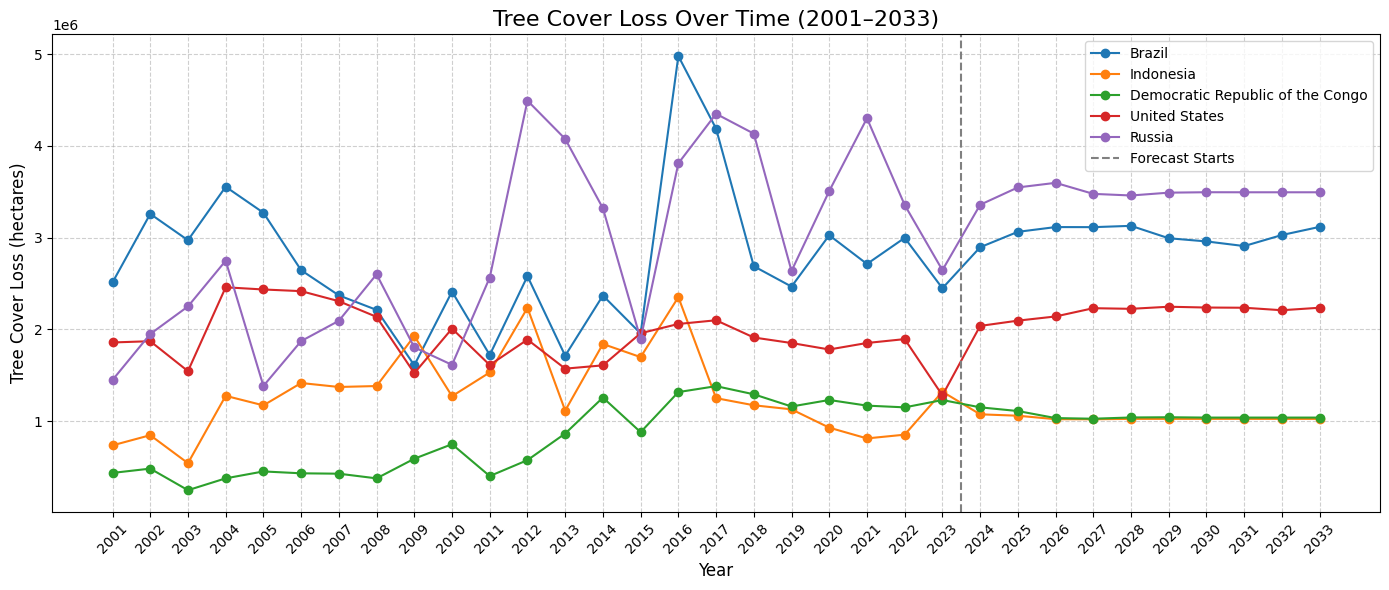

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Rename all columns to integers (years)
def convert_column(col):
    if isinstance(col, str) and col.startswith("tc_loss_"):
        return int(col.split("_")[-1])
    elif isinstance(col, int):
        return col
    else:
        return int(col)  # For forecast years that are already ints

combined.columns = [convert_column(col) for col in combined.columns]
combined = combined.sort_index(axis=1)

# Step 2: Plot
plt.figure(figsize=(14, 6))

for country in selected_countries:
    plt.plot(combined.columns, combined.loc[country], label=country, marker='o')

plt.axvline(2023.5, color='gray', linestyle='--', label='Forecast Starts')
plt.title("Tree Cover Loss Over Time (2001–2033)", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Tree Cover Loss (hectares)", fontsize=12)
plt.xticks(ticks=combined.columns, rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
